## Assignment 1: Perceptron Training
Neural Networks and Computational Intelligence

In [13]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(29) # makes the random numbers predictable

In [14]:
## a) Generate artificial data sets
P = 5      # number of feature vectors 
N = 3      # dim of feature vectors

def datasets(N, P):
    D = np.zeros((N+1, P))       # empty data set (each column is a vector, last el. is the label)
    for mu in range(P):
        D[:-1, mu] = np.random.normal(0, 1, size=N)
        D[-1, mu] = np.random.randint(0, 2, size=1)        # the labels are 0 and 1 not -+1
        if D[-1, mu] == 0:
            D[-1, mu] = -1
    return D

D = datasets(N, P)
print(D)

[[-0.41748213 -2.1417555  -0.89422358  0.10193307  0.98494561]
 [ 0.7060321   0.23407402  0.80802964 -1.19332572 -1.1444064 ]
 [ 1.9159847   0.25027325 -0.20433129  0.00373976  0.38683645]
 [ 1.          1.          1.          1.         -1.        ]]


In [16]:
## b) Sequential perceptron training

n_max = 2     # max number of epochs (loops through D)
n = 1           # epoch counter
t = 0
while n <= n_max:
    print('epoch', n)
    for mu in range(P):
        print('mu('+str(t)+') = ', mu, ':', D[:-1, mu])
        t += 1 
    n += 1
print("Final t: ", t)

epoch 1
mu(0) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(1) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(2) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(3) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(4) =  4 : [ 0.98494561 -1.1444064   0.38683645]
epoch 2
mu(5) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(6) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(7) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(8) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(9) =  4 : [ 0.98494561 -1.1444064   0.38683645]
Final t:  10


In [19]:
## c) Rosenblatt algorithm
def Ros_alg(N, P, D, n_max, verbose=False):
    w = np.zeros(N)      # weight vector
    E_mu = np.zeros(P)    # local potentials (one per input vector)
    n = 1
    #t = 0
    success = False
    while n <= n_max:
        #print('epoch', n)
        for mu in range(P):
            if E_mu[mu] <= 0:
                w += D[:-1, mu] * D[-1, mu] / N
            E_mu[mu] = np.dot(w, D[:-1, mu]) * D[-1, mu]
            #print(E_mu)
        #t += 1
        if not np.any(E_mu <= 0):
            success = True
            break
        n += 1
        
    if verbose:
        print("Success: {} after {} out of {} max epochs".format(success, n, n_max))
        
    return w, n, success

n_max = 10
w, n, s = Ros_alg(N, P, D, n_max, verbose=True)

Success: True after 3 out of 10 max epochs


In [25]:
## Rosenblatt validation algorithm
def Ros_alg_theoretical(N, P, verbose=False):
    if P <= N:
        P_ls = 1
    else:
        P_ls = 0
        for ii in range(0, N):
            P_ls += np.math.factorial(P - 1) / (np.math.factorial(ii) * np.math.factorial(P - 1 - ii))
        P_ls *= 2**(1 - P)
        
    if verbose:
        print("P_ls of N = {}, P = {} -> {:.3f}".format(N, P, P_ls))
    
    return P_ls

a = Ros_alg_theoretical(N, P, verbose=True)

P_ls of N = 3, P = 5 -> 0.688


array([0.75, 1.5 , 2.25, 3.  ])

In [49]:
## d) Running the experiments

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.05
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N = [5, 20, 40]
colors = ["b", "r", "c", "g", "y", "m", "k"]
n_D = 100 * 2   # number of random datasets for each P
n_max = 100*15     # max number of epochs 

P_ls = np.zeros((len(alpha), len(N)))
P_ls_theoretical = np.zeros((len(alpha), len(N)))

for aa in range(len(alpha)):
    print("It of alpha: {} out of {}".format(aa + 1, len(alpha)))
    for n_dim in N: 
        successful_runs = 0
        
        P = int(n_dim * alpha[aa])
        for dd in range(n_D):
            D = datasets(n_dim, P) # new generated dataset
            ww, nn, ss = Ros_alg(n_dim, P, D, n_max)    #I think I dont need w for anything
            successful_runs += ss
            
        P_ls[aa, N.index(n_dim)] = successful_runs / n_D
        P_ls_theoretical[aa, N.index(n_dim)] = Ros_alg_theoretical(n_dim, P)


It of alpha: 1 out of 45
It of alpha: 2 out of 45
It of alpha: 3 out of 45
It of alpha: 4 out of 45
It of alpha: 5 out of 45
It of alpha: 6 out of 45
It of alpha: 7 out of 45
It of alpha: 8 out of 45
It of alpha: 9 out of 45
It of alpha: 10 out of 45
It of alpha: 11 out of 45
It of alpha: 12 out of 45
It of alpha: 13 out of 45
It of alpha: 14 out of 45
It of alpha: 15 out of 45
It of alpha: 16 out of 45
It of alpha: 17 out of 45
It of alpha: 18 out of 45
It of alpha: 19 out of 45
It of alpha: 20 out of 45
It of alpha: 21 out of 45
It of alpha: 22 out of 45
It of alpha: 23 out of 45
It of alpha: 24 out of 45
It of alpha: 25 out of 45
It of alpha: 26 out of 45
It of alpha: 27 out of 45
It of alpha: 28 out of 45
It of alpha: 29 out of 45
It of alpha: 30 out of 45
It of alpha: 31 out of 45
It of alpha: 32 out of 45
It of alpha: 33 out of 45
It of alpha: 34 out of 45
It of alpha: 35 out of 45
It of alpha: 36 out of 45
It of alpha: 37 out of 45
It of alpha: 38 out of 45
It of alpha: 39 out o

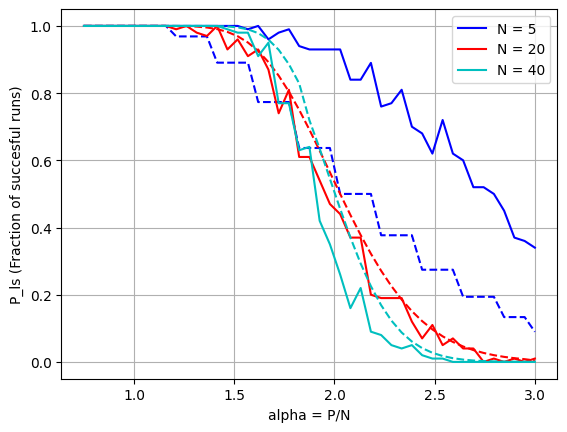

In [50]:
            
plt.figure()
for ii in range(len(N)):
    plt.plot(alpha, P_ls[:, ii], colors[ii]+"-", label="N = {}".format(N[ii]))
    plt.plot(alpha, P_ls_theoretical[:, ii], colors[ii]+"--")

plt.xlabel('alpha = P/N')
plt.ylabel('P_ls (Fraction of succesful runs)')
plt.grid()
plt.legend()
plt.show()
